#  Ujednolicanie klas w adnotacjach COCO

###  Opis
Notebook służy do **ujednolicania nazw klas** w plikach adnotacji COCO (`_annotations.coco.json`) 
dla różnych zbiorów danych dotyczących **detekcji obiektów pływających** (np. statków, łodzi, okrętów podwodnych).

Celem jest:
- przetworzenie wszystkich plików COCO w katalogu `datasets_coco`,  
- dopasowanie nazw klas do wspólnego słownika (`class_mapping`),  
- utworzenie zunifikowanych plików COCO oraz jednego zbiorczego pliku CSV.

###  Efekty działania
- `_annotations_unified.coco.json` – nowe pliki adnotacji z ujednoliconymi klasami,  
- `all_labels_unified.csv` – plik CSV zawierający wszystkie adnotacje i klasy,  
- statystyka liczby obiektów dla każdej klasy,  
- lista nieznanych klas wymagających dopisania do mapowania.

## Importy i ustawienia bazowe

In [1]:
import os
import json
import pandas as pd

# Ustawienia bazowe
base_dir = "datasets_coco"                                          # folder główny ze zbiorami COCO
output_csv = os.path.join(base_dir, "all_labels_unified.csv")       # plik wynikowy CSV

## Słownik mapowania klas

In [2]:
class_mapping = {
    # Military - Warships
    "aircraft carrier": ("Aircraft carrier", "Sea", "Military"),
    "carrier": ("Aircraft carrier", "Sea", "Military"),
    "lotniskowiec": ("Aircraft carrier", "Sea", "Military"),

    "niszczyciel rakietowy": ("Destroyer", "Sea", "Military"),
    "krazownik rakietowy": ("Cruise", "Sea", "Military"),
    "warship": ("Warship", "Sea", "Military"),
    "container-warship-ships-buoys": ("Warship", "Sea", "Military"),
    "przybrzezny okret bojowy": ("Warship", "Sea", "Military"),

    "okret desantowy": ("Landing ship", "Sea", "Military"),
    "uniwersalny okret desantowy": ("Landing ship", "Sea", "Military"),

    "okret podwodny": ("Submarine", "Sea", "Military"),
    "submarine": ("Submarine", "Sea", "Military"),

    # Civilian / Transport ships
    "cargo": ("Container ship", "Sea", "Transport/Civilian"),
    "container": ("Container ship", "Sea", "Transport/Civilian"),
    "container ship": ("Container ship", "Sea", "Transport/Civilian"),
    "tanker": ("Tanker", "Sea", "Transport/Civilian"),
    "cruise": ("Cruise", "Sea", "Civilian/Transport"),
    "ships": ("Civilian ship", "Sea", "Civilian/Military"),
    "vessel-z4gu": ("Civilian ship", "Sea", "Civilian/Military"),
    "civilianship": ("Civilian ship", "Sea", "Civilian"),
    "merchant_ship": ("Civilian ship", "Sea", "Transport/Civilian"),
    "barge": ("Barge", "Sea", "Transport/Civilian"),

    # Small civilian vessels
    "canoe": ("Canoe", "Sea", "Civilian"),
    "sail boat": ("Sail boat", "Sea", "Civilian"),
    "sailboat": ("Sail boat", "Sea", "Civilian"),
    "speedboat": ("Boat", "Sea", "Civilian/Military"),
    "fish-b": ("Fishing boat", "Sea", "Civilian"),
    "fishing_boat": ("Fishing boat", "Sea", "Civilian"),
    "yacht": ("Yacht", "Sea", "Civilian"),
    "boat": ("Boat", "Sea", "Civilian"),

    # Emergency / Coastguard
    "coastguard": ("Coastguard ship", "Sea", "Emergency/Military"),

    # Miscellaneous / Others
    "buoy": ("Buoy", "Sea", "Civilian"),
    "beacon": ("Container ship", "Sea", "Civilian"),
    "human-drowning": ("Human", "Sea", "Civilian"),
    "human-swimming": ("Human", "Sea", "Civilian"),
    "human-water": ("Human", "Sea", "Civilian"),
    "person": ("Human", "Sea", "Civilian"),
    "object": ("Unknown Object", "Sea", "Miscellaneous"),
    "object-detection": ("Unknown Object", "Sea", "Miscellaneous"),
    "bridge": ("Bridge", "Sea", "Infrastructure"),
    "ship": ("Ship", "Sea", "Civilian/Military"),

    # Nowe YOLO klasy (0–9) - numeric keys
    0: ("Aircraft carrier", "Sea", "Military"),
    1: ("Bulkers", "Sea", "Transport/Civilian"),
    2: ("Car carrier", "Sea", "Transport/Civilian"),
    3: ("Container ship", "Sea", "Transport/Civilian"),
    4: ("Cruise", "Sea", "Civilian/Transport"),
    5: ("Destroyer", "Sea", "Military"),
    6: ("Recreational", "Sea", "Civilian"),
    7: ("Boat", "Sea", "Civilian"),
    8: ("Submarine", "Sea", "Military"),
    9: ("Tug", "Sea", "Civilian"),
}

## Funkcja pomocnicza find_mapping -wyszukiwanie klas

In [3]:
def find_mapping(orig_raw):
    
    # Zwracanie tuple z class_mapping lub None.
    
    # przygotowanie
    candidates = []

    if isinstance(orig_raw, int):
        candidates.append(orig_raw)
        candidates.append(str(orig_raw))
        candidates.append(str(orig_raw).lower())
    else:
        s = str(orig_raw).strip()
        # Obsługa string -> int
        if s.isdigit():
            candidates.append(int(s))
        candidates.append(s)
        candidates.append(s.lower())
        # Usuwanie znaków
        candidates.append(s.replace("_", " ").replace("-", " ").lower())
        candidates.append(s.replace("_", "-").lower())
        candidates.append(s.replace("-", "_").lower())

    for c in candidates:
        if c in class_mapping:
            return class_mapping[c]
    return None

## Przetwarzanie plików COCO i generowanie CSV oraz zunifikowanych adnotacji

In [4]:
# Inicjalizacja listy rekordów do pliku CSV
rows = []

# Zbiór oryginalnych klas, które nie zostały zmapowane
unknown_orig_classes = set()

# Iteracja po katalogach w folderze bazowym (datasets_coco)
# Każdy katalog traktowany jako osobny zbiór danych

for dataset_name in os.listdir(base_dir):
    dataset_path = os.path.join(base_dir, dataset_name)
    if not os.path.isdir(dataset_path):
        continue

    # Obsługa podzbiorów danych: train / valid / test
    for split in ["train", "valid", "test"]:
        json_path = os.path.join(dataset_path, split, "_annotations.coco.json")

        # Pominięcie, jeśli plik z adnotacjami nie istnieje
        if not os.path.exists(json_path):
            print(f"  Brak pliku: {json_path}")
            continue

        # Wczytywanie danych COCO z pliku JSON
        with open(json_path, "r", encoding="utf-8") as f:
            coco = json.load(f)

        # Mapowanie ID obrazu → nazwa pliku
        img_map = {img["id"]: img["file_name"] for img in coco.get("images", [])}

        # Mapowanie ID kategorii → oryginalna nazwa klasy
        cat_map = {cat["id"]: str(cat.get("name", "")).strip() for cat in coco.get("categories", [])}

        # Struktura nowego pliku COCO
        new_coco = {
            "images": coco.get("images", []),
            "annotations": [],
            "categories": [],
        }

        # Mapowanie zunifikowanych klas na nowe ID
        unified_class_to_id = {}
        next_cat_id = 1

        for ann in coco.get("annotations", []):
            image_file = img_map.get(ann["image_id"], "unknown")
            orig_raw = cat_map.get(ann["category_id"], "unknown")

            # Wyszukiwanie dopasowania w słowniku class_mapping
            mapping = find_mapping(orig_raw)
            if mapping is not None:
                unified_class, category_of_movement, vehicle_type = mapping
            else:
                # Brak dopasowania → oznaczenie jako Unknown
                unified_class, category_of_movement, vehicle_type = ("Unknown", "Unknown", "Unknown")
                unknown_orig_classes.add(orig_raw)

            # Nadawanie ID nowej kategorii, jeśli nie istnieje
            if unified_class not in unified_class_to_id:
                unified_class_to_id[unified_class] = next_cat_id
                next_cat_id += 1

            # Tworzenie nowej adnotacji z uaktualnionym ID kategorii
            new_ann = ann.copy()
            new_ann["category_id"] = unified_class_to_id[unified_class]
            new_coco["annotations"].append(new_ann)

            # Pobieranie współrzędnych ramki
            x, y, w, h = ann.get("bbox", [None, None, None, None])

            # Generowanie pełnej ścieżki do obrazu
            image_path = os.path.abspath(os.path.join(dataset_path, split, image_file))

            # Zapis pojedynczej adnotacji do listy rekordów CSV
            rows.append({
                "dataset": dataset_name,
                "split": split,
                "image_file": image_file,
                "image_path": image_path,
                "original_class_raw": orig_raw,
                "unified_class": unified_class,
                "category_of_movement": category_of_movement,
                "vehicle_type": vehicle_type,
                "x": x,
                "y": y,
                "width": w,
                "height": h,
            })

        # Dodawanie kategorii do nowego pliku COCO
        for unified_class, cid in unified_class_to_id.items():
            new_coco["categories"].append({
                "id": cid,
                "name": unified_class,
                "supercategory": "ship",
            })

        # Zapis nowego pliku COCO z ujednoliconymi klasami
        new_json_path = os.path.join(dataset_path, split, "_annotations_unified.coco.json")
        with open(new_json_path, "w", encoding="utf-8") as f:
            json.dump(new_coco, f, indent=2, ensure_ascii=False)

        print(f" Utworzono plik COCO: {new_json_path}")
        

 Utworzono plik COCO: datasets_coco\universe_1\train\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_1\valid\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_1\test\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_2\train\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_2\valid\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_2\test\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_3\train\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_3\valid\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_3\test\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_4\train\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_4\valid\_annotations_unified.coco.json
 Utworzono plik COCO: datasets_coco\universe_4\test\_annotations_unified.coco.j

## Tworzenie pliku CSV ze wszystkimi adnotacjami

In [5]:
df = pd.DataFrame(rows)
df.to_csv(output_csv, index=False, encoding="utf-8")
print(f"\n Zapisano {len(df)} adnotacji do CSV: {output_csv}")


 Zapisano 76823 adnotacji do CSV: datasets_coco\all_labels_unified.csv


## Generowanie zestawienia liczby obiektów dla każdej klasy

In [6]:
summary = (
    df.groupby("unified_class")
      .size()
      .reset_index(name="object_count")
      .sort_values("object_count", ascending=False)
)
print("\n Liczba obiektów dla każdej klasy:")
print(summary.to_string(index=False))


 Liczba obiektów dla każdej klasy:
   unified_class  object_count
         Warship         12022
          Cruise         11112
    Fishing boat          8178
  Container ship          7225
       Sail boat          5978
   Civilian ship          5949
            Buoy          3941
            Boat          3468
           Canoe          3286
Aircraft carrier          2741
       Destroyer          2713
     Car carrier          2041
           Human          1923
       Submarine          1852
    Landing ship          1390
          Tanker          1268
             Tug           915
 Coastguard ship           328
    Recreational           263
         Bulkers           230


## Wyświetlenie listy nieznanych klas, które wymagają dopisania do class_mapping

In [7]:
if unknown_orig_classes:
    print("\n Nieznane oryginalne klasy (do dopisania w class_mapping):")
    for u in sorted(unknown_orig_classes):
        print(" -", repr(u))
else:
    print("\n  Wszystkie klasy zmapowane poprawnie.")


  Wszystkie klasy zmapowane poprawnie.


## Statyskyki klas

 Podsumowanie liczby obiektów w klasach (Train / Valid / Test / Suma):

   unified_class  test  train  valid  total
Aircraft carrier   184   2224    333   2741
            Boat   303   2354    811   3468
         Bulkers    11    200     19    230
            Buoy   104   3612    225   3941
           Canoe   432   2148    706   3286
     Car carrier    90   1772    179   2041
   Civilian ship  1743   3010   1196   5949
 Coastguard ship    26    236     66    328
  Container ship   397   6124    704   7225
          Cruise   535   9530   1047  11112
       Destroyer    94   2394    225   2713
    Fishing boat   355   7211    612   8178
           Human   183   1333    407   1923
    Landing ship    54   1229    107   1390
    Recreational    16    236     11    263
       Sail boat   435   4627    916   5978
       Submarine    95   1542    215   1852
          Tanker    82   1029    157   1268
             Tug    35    803     77    915
         Warship  1823   8454   1745  12022

 Łą

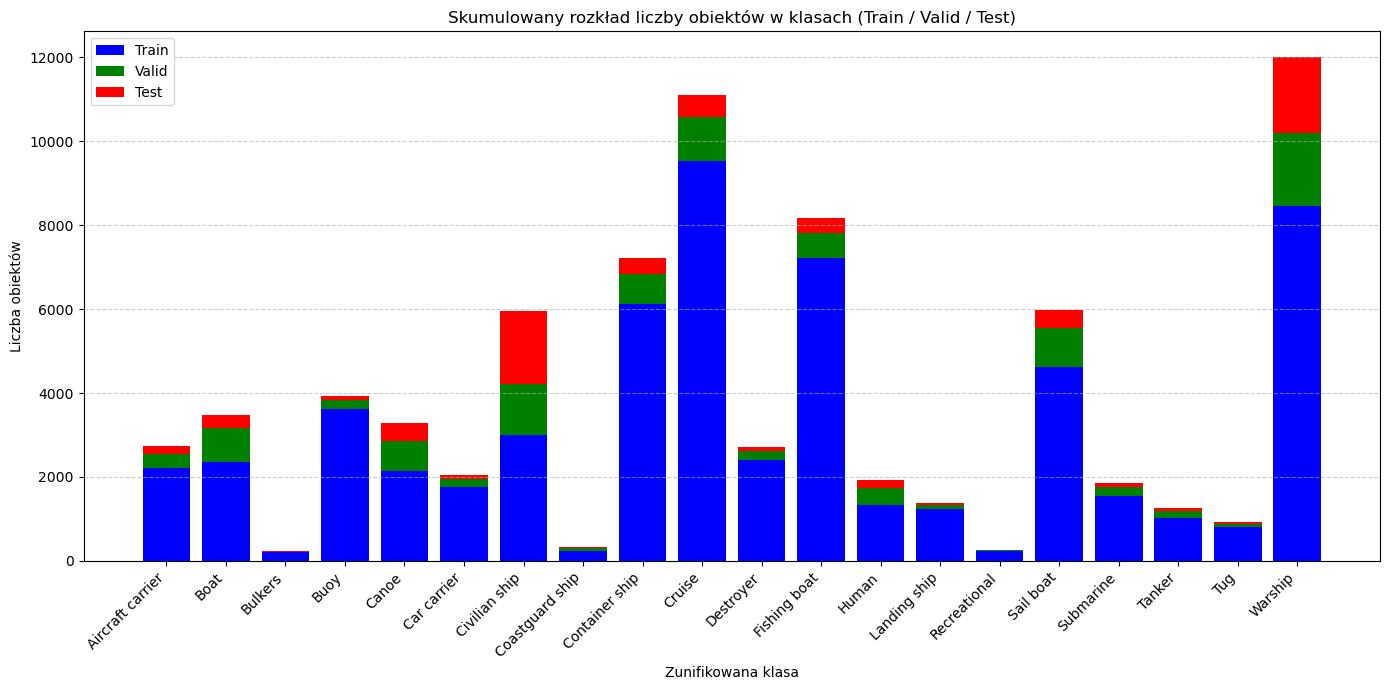

In [8]:
import matplotlib.pyplot as plt

# Grupowanie danych po klasie i zbiorze
split_summary = (
    df.groupby(["unified_class", "split"])
      .size()
      .unstack(fill_value=0)
      .reset_index()
)

# Dodanie kolumny sumy
split_summary["total"] = split_summary[["train", "valid", "test"]].sum(axis=1)

# Wyświetlenie tabeli podsumowującej
print(" Podsumowanie liczby obiektów w klasach (Train / Valid / Test / Suma):\n")
print(split_summary.to_string(index=False))

# Całkowita liczba obiektów
total_objects = split_summary["total"].sum()
print(f"\n Łączna liczba wszystkich obiektów: {total_objects}")

# ==========================================
# Wykres słupkowy skumulowany (stacked bar chart)
# ==========================================
plt.figure(figsize=(14, 7))

# Pozycje słupków
x = range(len(split_summary))

# Rysowanie skumulowanych słupków
plt.bar(x, split_summary["train"], color='blue', label='Train')
plt.bar(x, split_summary["valid"], bottom=split_summary["train"], color='green', label='Valid')
plt.bar(
    x,
    split_summary["test"],
    bottom=split_summary["train"] + split_summary["valid"],
    color='red',
    label='Test'
)

# Opisy osi i legenda
plt.xticks(x, split_summary["unified_class"], rotation=45, ha='right')
plt.xlabel("Zunifikowana klasa")
plt.ylabel("Liczba obiektów")
plt.title("Skumulowany rozkład liczby obiektów w klasach (Train / Valid / Test)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Sprawdzenie liczby adnotacji w każdym zbiorze danych

In [9]:
split_counts = df["split"].value_counts()
total_count = split_counts.sum()

print(" Liczba adnotacji w każdym zbiorze danych:\n")
for split, count in split_counts.items():
    percent = (count / total_count) * 100
    print(f" - {split.capitalize():<10}: {count:>6} ({percent:5.2f}%)")

print(f"\n Łączna liczba wszystkich adnotacji: {total_count}")

 Liczba adnotacji w każdym zbiorze danych:

 - Train     :  60068 (78.19%)
 - Valid     :   9758 (12.70%)
 - Test      :   6997 ( 9.11%)

 Łączna liczba wszystkich adnotacji: 76823
